# RESTAURANT - EDA

In this competition, you are provided a time-series forecasting problem centered around restaurant visitors. The data comes from two separate sites:

Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system
You must use the reservations, visits, and other information from these sites to forecast future restaurant visitor totals on a given date. The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.

notes:
- ”There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import os

In [2]:
%matplotlib inline

In [3]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [4]:
# global vars
sns.set_palette("PRGn", 10)

# IMPORT DATA

In [5]:
path_input = ('../input/')

In [6]:
air_visits = pd.read_csv(os.path.join(path_input,'air_visit_data.csv.gz'))
air_reserve = pd.read_csv(os.path.join(path_input,'air_reserve.csv.gz'))
hpg_reserve = pd.read_csv(os.path.join(path_input,'hpg_reserve.csv.gz'))
air_store = pd.read_csv(os.path.join(path_input,'air_store_info.csv.gz'))
hpg_store = pd.read_csv(os.path.join(path_input,'hpg_store_info.csv.gz'))
holidays = pd.read_csv(os.path.join(path_input,'date_info.csv.gz'))
store_ids = pd.read_csv(os.path.join(path_input,'store_id_relation.csv.gz'))
test = pd.read_csv(os.path.join(path_input,'sample_submission.csv.gz'))

In [7]:
tables = [('air_visits',air_visits),
        ('air_reserve',air_reserve),
        ('hpg_reserve',hpg_reserve),
        ('air_store',air_store),
        ('hpg_store',hpg_store),
        ('holidays',holidays),
        ('store_ids',store_ids,),
        ('test',test)]

# OVERVIEW: FILE STRUCTURE AND CONTENT

#### air_visits

In [8]:
display(air_visits.dtypes)
display_side_by_side(air_visits.head(),air_visits.describe())
print(air_visits['air_store_id'].nunique())

air_store_id    object
visit_date      object
visitors         int64
dtype: object

air_store_id 
 visit_date 
 visitors 
 
 
 
 
 0 
 air_ba937bf13d40fb24 
 2016-01-13 
 25 
 
 
 1 
 air_ba937bf13d40fb24 
 2016-01-14 
 32 
 
 
 2 
 air_ba937bf13d40fb24 
 2016-01-15 
 29 
 
 
 3 
 air_ba937bf13d40fb24 
 2016-01-16 
 22 
 
 
 4 
 air_ba937bf13d40fb24 
 2016-01-18 
 6 
 
 
 
 
 
 
 visitors 
 
 
 
 
 count 
 252108.000000 
 
 
 mean 
 20.973761 
 
 
 std 
 16.757007 
 
 
 min 
 1.000000 
 
 
 25% 
 9.000000 
 
 
 50% 
 17.000000 
 
 
 75% 
 29.000000 
 
 
 max 
 877.000000

829


    air_visits
    We find that this file contains the visitors numbers for each visit_date and air_store_id. The date feature should be transformed into a time-series format. There are 829 different stores, which is a small data set.

In [9]:
air_visits['visit_date'] = pd.to_datetime(air_visits['visit_date'])

#### air_reserve

In [10]:
display(air_reserve.dtypes)
display_side_by_side(air_reserve.head(),air_reserve.describe())
print(air_reserve['air_store_id'].nunique())

air_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

air_store_id 
 visit_datetime 
 reserve_datetime 
 reserve_visitors 
 
 
 
 
 0 
 air_877f79706adbfb06 
 2016-01-01 19:00:00 
 2016-01-01 16:00:00 
 1 
 
 
 1 
 air_db4b38ebe7a7ceff 
 2016-01-01 19:00:00 
 2016-01-01 19:00:00 
 3 
 
 
 2 
 air_db4b38ebe7a7ceff 
 2016-01-01 19:00:00 
 2016-01-01 19:00:00 
 6 
 
 
 3 
 air_877f79706adbfb06 
 2016-01-01 20:00:00 
 2016-01-01 16:00:00 
 2 
 
 
 4 
 air_db80363d35f10926 
 2016-01-01 20:00:00 
 2016-01-01 01:00:00 
 5 
 
 
 
 
 
 
 reserve_visitors 
 
 
 
 
 count 
 92378.000000 
 
 
 mean 
 4.481749 
 
 
 std 
 4.919669 
 
 
 min 
 1.000000 
 
 
 25% 
 2.000000 
 
 
 50% 
 3.000000 
 
 
 75% 
 5.000000 
 
 
 max 
 100.000000

314


    air_reserve
    We find that the air reservations include the date and time of the reservation, as well as those of the visit. We have reservation numbers for 314 air stores:

In [11]:
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])

#### hpg_reserve

In [12]:
display(hpg_reserve.dtypes)
display_side_by_side(hpg_reserve.head(),hpg_reserve.describe())
display(hpg_reserve['hpg_store_id'].nunique())

hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

hpg_store_id 
 visit_datetime 
 reserve_datetime 
 reserve_visitors 
 
 
 
 
 0 
 hpg_c63f6f42e088e50f 
 2016-01-01 11:00:00 
 2016-01-01 09:00:00 
 1 
 
 
 1 
 hpg_dac72789163a3f47 
 2016-01-01 13:00:00 
 2016-01-01 06:00:00 
 3 
 
 
 2 
 hpg_c8e24dcf51ca1eb5 
 2016-01-01 16:00:00 
 2016-01-01 14:00:00 
 2 
 
 
 3 
 hpg_24bb207e5fd49d4a 
 2016-01-01 17:00:00 
 2016-01-01 11:00:00 
 5 
 
 
 4 
 hpg_25291c542ebb3bc2 
 2016-01-01 17:00:00 
 2016-01-01 03:00:00 
 13 
 
 
 
 
 
 
 reserve_visitors 
 
 
 
 
 count 
 2.000320e+06 
 
 
 mean 
 5.073785e+00 
 
 
 std 
 5.416172e+00 
 
 
 min 
 1.000000e+00 
 
 
 25% 
 2.000000e+00 
 
 
 50% 
 3.000000e+00 
 
 
 75% 
 6.000000e+00 
 
 
 max 
 1.000000e+02

13325

    hpg_reserve
    The hpg reservations file follows the same structure as the corresponding air file. We have reservation numbers for 13325 hpg stores


In [13]:
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime'])

#### air_store

In [14]:
display(air_store.dtypes)
display_side_by_side(air_store.head(),air_store.describe())
display(air_store['air_store_id'].nunique())

air_store_id       object
air_genre_name     object
air_area_name      object
latitude          float64
longitude         float64
dtype: object

air_store_id 
 air_genre_name 
 air_area_name 
 latitude 
 longitude 
 
 
 
 
 0 
 air_0f0cdeee6c9bf3d7 
 Italian/French 
 Hyōgo-ken Kōbe-shi Kumoidōri 
 34.695124 
 135.197852 
 
 
 1 
 air_7cc17a324ae5c7dc 
 Italian/French 
 Hyōgo-ken Kōbe-shi Kumoidōri 
 34.695124 
 135.197852 
 
 
 2 
 air_fee8dcf4d619598e 
 Italian/French 
 Hyōgo-ken Kōbe-shi Kumoidōri 
 34.695124 
 135.197852 
 
 
 3 
 air_a17f0778617c76e2 
 Italian/French 
 Hyōgo-ken Kōbe-shi Kumoidōri 
 34.695124 
 135.197852 
 
 
 4 
 air_83db5aff8f50478e 
 Italian/French 
 Tōkyō-to Minato-ku Shibakōen 
 35.658068 
 139.751599 
 
 
 
 
 
 
 latitude 
 longitude 
 
 
 
 
 count 
 829.000000 
 829.000000 
 
 
 mean 
 35.647042 
 137.415311 
 
 
 std 
 2.084659 
 3.650971 
 
 
 min 
 33.211967 
 130.195555 
 
 
 25% 
 34.695124 
 135.341564 
 
 
 50% 
 35.658068 
 139.685474 
 
 
 75% 
 35.694003 
 139.751599 
 
 
 max 
 44.020632 
 144.273398

829

    air_store
    We find that the air_store info includes the name of the particular cuisine along with the name of the area.
    Number of unique store id's match with the air_store table.

#### hpg_store

In [15]:
display(hpg_store.dtypes)
display_side_by_side(hpg_store.head(),hpg_store.describe())
display(hpg_store['hpg_store_id'].nunique())

hpg_store_id       object
hpg_genre_name     object
hpg_area_name      object
latitude          float64
longitude         float64
dtype: object

hpg_store_id 
 hpg_genre_name 
 hpg_area_name 
 latitude 
 longitude 
 
 
 
 
 0 
 hpg_6622b62385aec8bf 
 Japanese style 
 Tōkyō-to Setagaya-ku Taishidō 
 35.643675 
 139.668221 
 
 
 1 
 hpg_e9e068dd49c5fa00 
 Japanese style 
 Tōkyō-to Setagaya-ku Taishidō 
 35.643675 
 139.668221 
 
 
 2 
 hpg_2976f7acb4b3a3bc 
 Japanese style 
 Tōkyō-to Setagaya-ku Taishidō 
 35.643675 
 139.668221 
 
 
 3 
 hpg_e51a522e098f024c 
 Japanese style 
 Tōkyō-to Setagaya-ku Taishidō 
 35.643675 
 139.668221 
 
 
 4 
 hpg_e3d0e1519894f275 
 Japanese style 
 Tōkyō-to Setagaya-ku Taishidō 
 35.643675 
 139.668221 
 
 
 
 
 
 
 latitude 
 longitude 
 
 
 
 
 count 
 4690.000000 
 4690.000000 
 
 
 mean 
 35.810261 
 137.675816 
 
 
 std 
 2.138755 
 3.197233 
 
 
 min 
 33.311645 
 130.339313 
 
 
 25% 
 34.692109 
 135.498859 
 
 
 50% 
 35.659214 
 139.495733 
 
 
 75% 
 35.703381 
 139.737998 
 
 
 max 
 43.774846 
 143.714585

4690

    hpg_store
    Again, the hpg_store info follows the same structure as the air info. Here the genre_name includes the word style. It’s worth checking whether the same is true for the air data or whether it just refers to the specific “Japanese style”. There are 4690 different hpg_store_ids, which are significantly fewer than we have reservation data for.

#### holidays

In [16]:
display(holidays.dtypes)
display_side_by_side(holidays.head(),holidays.describe())

calendar_date    object
day_of_week      object
holiday_flg       int64
dtype: object

calendar_date 
 day_of_week 
 holiday_flg 
 
 
 
 
 0 
 2016-01-01 
 Friday 
 1 
 
 
 1 
 2016-01-02 
 Saturday 
 1 
 
 
 2 
 2016-01-03 
 Sunday 
 1 
 
 
 3 
 2016-01-04 
 Monday 
 0 
 
 
 4 
 2016-01-05 
 Tuesday 
 0 
 
 
 
 
 
 
 holiday_flg 
 
 
 
 
 count 
 517.000000 
 
 
 mean 
 0.067698 
 
 
 std 
 0.251471 
 
 
 min 
 0.000000 
 
 
 25% 
 0.000000 
 
 
 50% 
 0.000000 
 
 
 75% 
 0.000000 
 
 
 max 
 1.000000

    holidays 
    We called the date_info file holidays, because that’s essentially the information it contains. Holidays are encoded as binary flags in integer format. This should become a logical binary feature for exploration purposes.



In [17]:
holidays['calendar_date'] = pd.to_datetime(holidays['calendar_date'])

#### store_ids

In [18]:
display(store_ids.dtypes)
display_side_by_side(store_ids.head(),store_ids.describe())

air_store_id    object
hpg_store_id    object
dtype: object

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
,air_store_id,hpg_store_id
count,150,150
unique,150,150
top,air_f180301886c21375,hpg_8072ff2fb418e273
freq,1,1


    store_ids
    This is a relational file that connects the air and hpg ids. There are only 150 pairs, which is less than 20% of all air stores.

#### test

In [19]:
display(test.dtypes)
display_side_by_side(test.head(),test.describe())

id          object
visitors     int64
dtype: object

id 
 visitors 
 
 
 
 
 0 
 air_00a91d42b08b08d9_2017-04-23 
 0 
 
 
 1 
 air_00a91d42b08b08d9_2017-04-24 
 0 
 
 
 2 
 air_00a91d42b08b08d9_2017-04-25 
 0 
 
 
 3 
 air_00a91d42b08b08d9_2017-04-26 
 0 
 
 
 4 
 air_00a91d42b08b08d9_2017-04-27 
 0 
 
 
 
 
 
 
 visitors 
 
 
 
 
 count 
 32019.0 
 
 
 mean 
 0.0 
 
 
 std 
 0.0 
 
 
 min 
 0.0 
 
 
 25% 
 0.0 
 
 
 50% 
 0.0 
 
 
 75% 
 0.0 
 
 
 max 
 0.0

    test
    As noted in the data description, the id of the final submission file is a concatenation of the air_id and the date.

#### Missing Values

In [20]:
for table_name,table in tables:
    print(table_name,'isna: ',table.isna().sum().sum())


air_visits isna:  0
air_reserve isna:  0
hpg_reserve isna:  0
air_store isna:  0
hpg_store isna:  0
holidays isna:  0
store_ids isna:  0
test isna:  0


    No missing values

# INDIVIDUAL FEATURE VISUALISATIONS

## Air Visits
We start with the number of visits to the air restaurants. Here we plot the total number of visitors per day over the full training time range together with the median visitors per day of the week and month of the year:

In [21]:
air_visits.columns

Index(['air_store_id', 'visit_date', 'visitors'], dtype='object')

Text(0.5,1,'Total number of visitors per day over the full training time range')

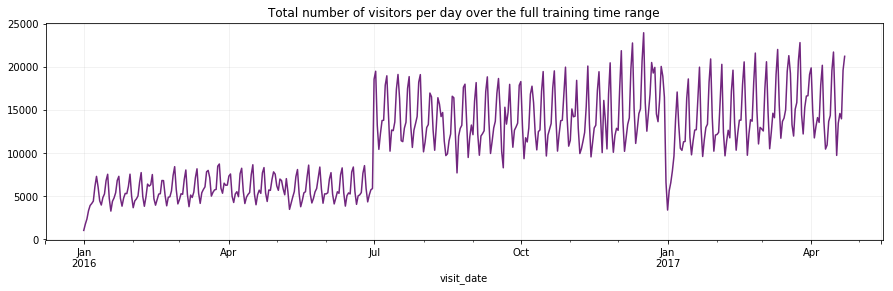

In [22]:
air_visits.groupby('visit_date')['visitors'].sum().plot(figsize=(15,4))
plt.grid(alpha=.2)
plt.title('Total number of visitors per day over the full training time range')


    There is an interesting long-term step structure in the overall time series. This might be related to new restaurants being added to the data base. In addition, we already see a periodic pattern that most likely corresponds to a weekly cycle.

In [23]:
air_visits['dow'] = air_visits.visit_date.dt.dayofweek
air_visits['month'] = air_visits.visit_date.dt.month

median_visitor_pday = air_visits.groupby(['dow'])['visitors'].median().reset_index()
median_visitor_pmonth = air_visits.groupby(['month'])['visitors'].median().reset_index()

median_visitor_pday['days'] = median_visitor_pday.dow.apply(lambda x : calendar.day_abbr[x])
median_visitor_pmonth['months'] = median_visitor_pmonth.month.apply(lambda x : calendar.month_abbr[x])

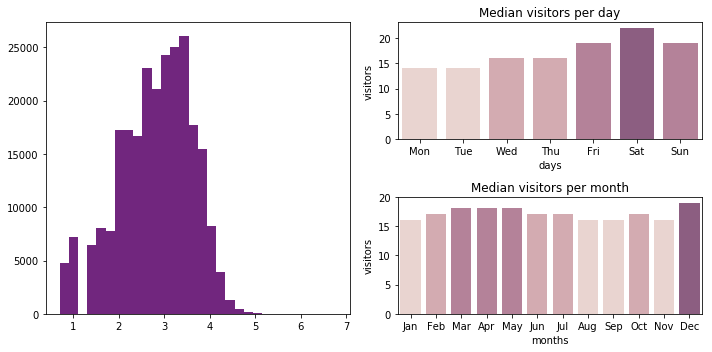

In [24]:
fig = plt.figure(figsize=(10,5)) 
ax1 = plt.subplot(222)
sns.barplot(y='visitors', x='days', hue='visitors', data=median_visitor_pday, dodge=False,
            palette = sns.cubehelix_palette(6),ax=ax1)
ax1.legend_.remove()
ax1.set_title('Median visitors per day')

ax2 = plt.subplot(224)
sns.barplot(y='visitors', x='months', data=median_visitor_pmonth, hue='visitors', dodge=False,
            palette = sns.cubehelix_palette(6),ax=ax2)
ax2.legend_.remove()
ax2.set_title('Median visitors per month')

ax3 = plt.subplot(121)
ax3.hist(np.log1p(air_visits['visitors']),bins=30)
plt.tight_layout();

    Friday and the weekend appear to be the most popular days; which is to be expected. Monday and Tuesday have the lowest numbers of average visitors.

    Also during the year there is a certain amount of variation. Dec appears to be the most popular month for restaurant visits. The period of Mar - May is consistently busy.

ref

https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda

https://www.kaggle.com/huntermcgushion/exhaustive-weather-eda-file-overview

https://www.kaggle.com/asindico/a-japanese-journey